<a href="https://colab.research.google.com/github/cff100/MecFLu2/blob/main/Dados_combinados_2023(HPA_300%2C_500%2C_700%2C_850%2C_925).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cdsapi
!pip install cartopy
!pip install netcdf4

import cdsapi
import xarray as xr
import pandas as pd

In [16]:
# Inicializa a API do CDS (Climate Data Store) com a URL e chave de acesso
c = cdsapi.Client(url='https://cds.climate.copernicus.eu/api/v2', key='331408:d8c35ac5-fae8-4f2e-90fe-b448d76e3140')

# Define a lista dos níveis de pressão que serão utilizados
pressure_levels = ['925', '850', '700', '500', '300']

In [17]:
# Define as localizações das plataformas de petróleo e gás com suas coordenadas de latitude e longitude
platforms = {
    'NAMORADO 2 (PNA-2)' :(-22.45073, -40.41175),
    'PETROBRAS 26 (P-26)' :(-22.4684, -40.02869),
    'PETROBRAS 32 (P-32)' :(-22.2051, -40.1431),
    'PETROBRAS 37 (P-37)' :(-22.4868, -40.09779),
    'PETROBRAS IX' :(-22.57358, -40.82192),
    'PETROBRAS XIX' :(-22.3927, -40.05438),
    'PETROBRAS XXXIII' :(-22.37, -40.0267),
    'VERMELHO 1 (PVM-1)' :(-22.16065, -40.27872),
    'VERMELHO 2 (PVM-2)' :(-22.17535, -40.29147),
}



In [ ]:
# Cria um DataFrame vazio para armazenar os resultados combinados de todas as pressões
combined_df = pd.DataFrame()

# Loop sobre cada nível de pressão
for level in pressure_levels:
    # Define o nome do arquivo NetCDF para o nível de pressão atual
    nc_filename = f'Era5_2023_{level}HPA_CAMPOS.nc'

    # Requisita os dados do CDS para o nível de pressão atual
    c.retrieve(
        'reanalysis-era5-pressure-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                'u_component_of_wind', 'v_component_of_wind',
            ],
            'pressure_level': level,
            'year': '2023',
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                -27, -45, -20, -35,  # Coordenadas da Bacia de Campos
            ],
        },
        nc_filename)

    # Carrega o arquivo NetCDF usando xarray
    ds = xr.open_dataset(nc_filename)

    # Calcula a velocidade do vento (wspd) a partir das componentes u e v
    u = ds['u']
    v = ds['v']
    wspd = (u**2 + v**2)**0.5

    # Calcula a média da velocidade do vento para cada ponto de grade ao longo dos horários e dias, agrupando por estação do ano
    wspd_mean_season = wspd.groupby('time.season').mean(dim=['time'])

    # Cria um DataFrame para armazenar os resultados específicos para o nível de pressão atual
    result_df = pd.DataFrame(index=platforms.keys())

    # Loop sobre as estações do ano
    for season in ['DJF', 'MAM', 'JJA', 'SON']:
        for platform, (lat, lon) in platforms.items():
            # Obtém o valor da média da velocidade do vento para a plataforma e estação do ano específicos
            value = wspd_mean_season.sel(season=season).interp(latitude=lat, longitude=lon, method='nearest').values.item()
            result_df.loc[platform, f'{season}_{level}HPA'] = value

    # Adiciona o DataFrame do nível de pressão atual ao DataFrame combinado
    combined_df = pd.concat([combined_df, result_df], axis=1)

    # Fecha o arquivo NetCDF
    ds.close()



In [19]:
# Salva o DataFrame combinado como CSV
combined_df.to_csv('2023_combined_pressure_levels.csv', index=True)

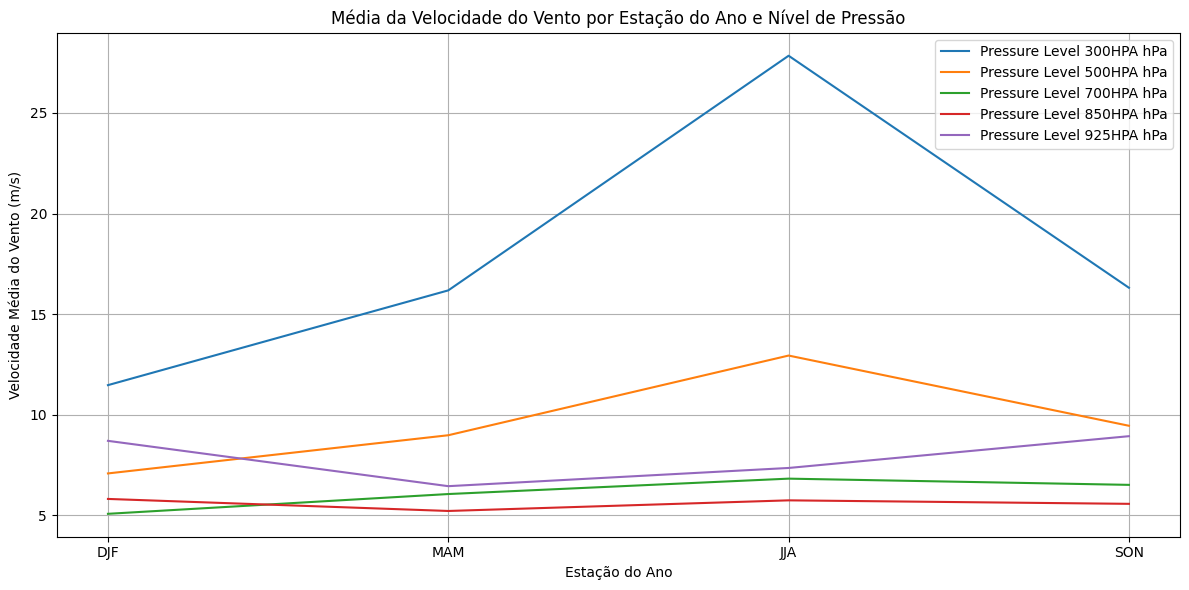

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Carrega o DataFrame combinado a partir do arquivo CSV
df = pd.read_csv('2023_combined_pressure_levels.csv', index_col=0)

# Define a ordem das estações do ano para garantir a ordem correta no gráfico
stations = ['DJF', 'MAM', 'JJA', 'SON']

# Cria um gráfico para visualizar a média da velocidade do vento por estação do ano e nível de pressão
plt.figure(figsize=(12, 6))

# Loop sobre os níveis de pressão (extraídos do nome das colunas)
pressure_levels = [col.split('_')[-1] for col in df.columns if '_' in col]
pressure_levels = sorted(set(pressure_levels))  # Remove duplicatas e ordena

for level in pressure_levels:
    # Filtra as colunas para o nível de pressão atual
    level_columns = [col for col in df.columns if col.endswith(f'{level}')]

    # Para cada nível de pressão, plota as curvas
    if level_columns: # Verifica se há colunas para o nível de pressão atual
        plt.plot(stations, df[level_columns].mean(axis=0), label=f'Pressure Level {level} hPa')

# Adiciona título e rótulos aos eixos
plt.title('Média da Velocidade do Vento por Estação do Ano e Nível de Pressão')
plt.xlabel('Estação do Ano')
plt.ylabel('Velocidade Média do Vento (m/s)')
plt.legend()
plt.grid(True)

# Salva o gráfico em um arquivo PNG e exibe o gráfico
plt.tight_layout()
plt.savefig('VelocidadeXEstação_do_ano.png')
plt.show()